In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import math
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [13]:
# whether to run on GPU or CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} device")
#print(torch.cuda.get_device_name(0))

#Checking how many files are in repository for training, testing, and validation
files = glob.glob('600MHz/spectral_data_*.csv')
print('Total number of files: ', len(files))



Using cpu device
Total number of files:  100


In [14]:
class GHzData(Dataset):
    def __init__(self):
        # Data loading starting with list of csv strings
        self.files = glob.glob(os.path.join('600MHz/spectral_data_*.csv'))

        self.y_60 = [] # Establishes a list for 60 MHz data
        self.y_600 = [] # Establishes a list for 600 MHz data

        for self.file in self.files: # For loop for each file in files
            self.df = pd.read_csv(self.file) # Reads each into a pandas dataframe
            self.array_60 = self.df['60MHz_intensity'].to_numpy() # Takes 60MHz intensity to np
            self.array_600 = self.df['600MHz_intensity'].to_numpy() # Takes 400MHz intensity to np
            self.y_60.append(self.array_60) # Appends all arrays to 60MHz list
            self.y_600.append(self.array_600) # Appends all arrays to 400MHz list
            
        # Creates a 60 MHz tensor from list, converts to float, unsqueezes to have shape (n, 1, 5500)
        self.tensor_60 = torch.Tensor(self.y_60).float().unsqueeze(1).to(device)        

        # Creates a 400 MHz tensor from list, converts to float, unsqueezes to have shape (n, 1, 5500)
        self.tensor_600 = torch.Tensor(self.y_600).float().unsqueeze(1).to(device)
        
        # Track the length of number of samples in frame
        self.num_samples = len(self.y_60)

    def __getitem__(self, index): # establishes an index for the tensors
        return self.tensor_60[index], self.tensor_600[index]
    
    def __len__(self): # Returns variable number of samples
        return self.num_samples

In [15]:
 #Establishing and loading data into notebook
dataset = GHzData()

#Splitting the data
train_X, test_X, train_y, test_y = train_test_split(dataset.tensor_60, dataset.tensor_600,
                                                    test_size=0.1)

# Splits train data into validation data
train_X, valid_X, train_y, valid_y = train_test_split(train_X, train_y,
                                                      test_size=0.1)
# Creating datasets
train_dataset = TensorDataset(train_X, train_y)
test_dataset = TensorDataset(test_X, test_y)
valid_dataset = TensorDataset(valid_X, valid_y)

# Batch size change to higher batch sizes
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True,drop_last=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [16]:
# Display  size train_loader
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([8, 1, 5500])
Labels batch shape: torch.Size([8, 1, 5500])


In [17]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(5500, 100)
        self.fc2 = nn.Linear(100, 300)
        self.fc3 = nn.Linear(300, 200)
        self.fc4 = nn.Linear(200, 100)
        self.fc5 = nn.Linear(100, 5500)
        self.activation = nn.Tanh()
    def forward(self, x):
        x = nn.ReLU()(self.fc1(x))
        x = nn.ReLU()(self.fc2(x))
        x = nn.ReLU()(self.fc3(x))
        x = nn.ReLU()(self.fc4(x))
        x = self.fc5(x)
        return x

In [18]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(5500, 100)
        self.fc2 = nn.Linear(100, 300)
        self.fc3 = nn.Linear(300, 200)
        self.fc4 = nn.Linear(200, 100)
        self.fc5 = nn.Linear(100, 5500)
        self.activation = nn.Sigmoid()
    def forward(self, x):
        x = nn.ReLU()(self.fc1(x))
        x = nn.ReLU()(self.fc2(x))
        x = nn.ReLU()(self.fc3(x))
        x = nn.ReLU()(self.fc4(x))
        x = nn.Sigmoid()(self.fc5(x))
        return x


In [19]:
def train_gan(generator, discriminator, train_loader, num_epochs):
    criterion = nn.BCELoss()
    optimizer_g = optim.Adam(generator.parameters(), lr=0.001)
    optimizer_d = optim.Adam(discriminator.parameters(), lr=0.001)
    #total_step = len(data_loader)
    
    #def reset_grad():
    #d_optimizer.zero_grad()
    #g_optimizer.zero_grad()
    
    # define labels for real and fake samples
    real_label = torch.ones([8,5500])
    fake_label = torch.zeros([8,5500])
    
    # create empty lists to store loss values
    d_losses = []
    g_losses = []

    for epoch in range(num_epochs):
        
        for index,(x_real,_) in enumerate(train_dataloader):
            x_real = x_real.view(8,5500).to(device)
            
            
            # train discriminator
            # train discriminator on real samples
            
            d_real = discriminator(x_real)
            loss_d_real = criterion(d_real, real_label)
            real_score = loss_d_real.mean().item()
            
            # generate fake samples
            x_fake = generator(torch.randn(8,x_real.shape[1]).to(device))
            
            # train discriminator on fake samples
            d_fake = discriminator(x_fake.detach())
            loss_d_fake = criterion(d_fake, fake_label)
            fake_score = loss_d_fake.mean().item()
            
            
            # calculate total discriminator loss
            d_loss = loss_d_real + loss_d_fake
            optimizer_d.zero_grad()
            optimizer_g.zero_grad()
            loss_d_fake.backward()
            optimizer_d.step()
            
            # train generator
            # generate samples
            x_fake = generator(torch.randn(8,x_real.shape[1]).to(device))
            
            d_fake = discriminator(x_fake)
            
            loss_g = criterion(d_fake, real_label)
            loss_g.backward()
            optimizer_g.step()
        
            # calculate total generator loss
            g_loss = loss_g
        
            # store loss values
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
        
            # print loss values
            if epoch % 10 == 0:
                print(f"Epoch {epoch+1}/{num_epochs}, D_loss: {d_loss.item():.4f}, G_loss: {g_loss.item():.4f}")

    # plot loss curves
    plt.plot(d_losses, label="Discriminator")
    plt.plot(g_losses, label="Generator")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("GAN Training Loss")
    plt.legend()
    plt.show()


Epoch 1/1000, D_loss: 1.3872, G_loss: 0.6954
Epoch 1/1000, D_loss: 1.3871, G_loss: 0.6978
Epoch 1/1000, D_loss: 1.3864, G_loss: 0.7016
Epoch 1/1000, D_loss: 1.3848, G_loss: 0.7079
Epoch 1/1000, D_loss: 1.3814, G_loss: 0.7181
Epoch 1/1000, D_loss: 1.3758, G_loss: 0.7334
Epoch 1/1000, D_loss: 1.3673, G_loss: 0.7549
Epoch 1/1000, D_loss: 1.3579, G_loss: 0.7848
Epoch 1/1000, D_loss: 1.3460, G_loss: 0.8172
Epoch 1/1000, D_loss: 1.3443, G_loss: 0.8553
Epoch 11/1000, D_loss: 13.9692, G_loss: 10.2528
Epoch 11/1000, D_loss: 17.1590, G_loss: 10.5065
Epoch 11/1000, D_loss: 22.9607, G_loss: 10.3601
Epoch 11/1000, D_loss: 16.3521, G_loss: 10.4815
Epoch 11/1000, D_loss: 22.4041, G_loss: 10.8486
Epoch 11/1000, D_loss: 20.9085, G_loss: 11.5101
Epoch 11/1000, D_loss: 18.2015, G_loss: 11.4883
Epoch 11/1000, D_loss: 24.8486, G_loss: 11.6173
Epoch 11/1000, D_loss: 17.7305, G_loss: 11.4071
Epoch 11/1000, D_loss: 16.4638, G_loss: 11.5874
Epoch 21/1000, D_loss: 42.7036, G_loss: 12.0559
Epoch 21/1000, D_loss:

Epoch 171/1000, D_loss: 60.4405, G_loss: 17.6161
Epoch 171/1000, D_loss: 62.8979, G_loss: 17.6173
Epoch 171/1000, D_loss: 55.5690, G_loss: 17.6186
Epoch 171/1000, D_loss: 50.4450, G_loss: 17.6198
Epoch 171/1000, D_loss: 56.2088, G_loss: 17.6211
Epoch 171/1000, D_loss: 52.6471, G_loss: 17.6223
Epoch 171/1000, D_loss: 54.9322, G_loss: 17.6235
Epoch 171/1000, D_loss: 54.6783, G_loss: 17.6248
Epoch 171/1000, D_loss: 46.9230, G_loss: 17.6260
Epoch 171/1000, D_loss: 52.5446, G_loss: 17.6273
Epoch 181/1000, D_loss: 55.3561, G_loss: 17.7373
Epoch 181/1000, D_loss: 61.8013, G_loss: 17.7385
Epoch 181/1000, D_loss: 48.9773, G_loss: 17.7397
Epoch 181/1000, D_loss: 72.3390, G_loss: 17.7408
Epoch 181/1000, D_loss: 45.5731, G_loss: 17.7420
Epoch 181/1000, D_loss: 54.5531, G_loss: 17.7432
Epoch 181/1000, D_loss: 57.8776, G_loss: 17.7444
Epoch 181/1000, D_loss: 48.8559, G_loss: 17.7456
Epoch 181/1000, D_loss: 47.6247, G_loss: 17.7467
Epoch 181/1000, D_loss: 55.8574, G_loss: 17.7479
Epoch 191/1000, D_lo

Epoch 341/1000, D_loss: 52.8248, G_loss: 19.1826
Epoch 341/1000, D_loss: 59.1748, G_loss: 19.1833
Epoch 341/1000, D_loss: 73.0151, G_loss: 19.1840
Epoch 341/1000, D_loss: 50.5334, G_loss: 19.1848
Epoch 341/1000, D_loss: 56.4293, G_loss: 19.1855
Epoch 341/1000, D_loss: 60.6584, G_loss: 19.1862
Epoch 341/1000, D_loss: 52.3241, G_loss: 19.1869
Epoch 341/1000, D_loss: 72.5023, G_loss: 19.1877
Epoch 341/1000, D_loss: 54.0684, G_loss: 19.1884
Epoch 341/1000, D_loss: 51.6685, G_loss: 19.1891
Epoch 351/1000, D_loss: 53.0001, G_loss: 19.2546
Epoch 351/1000, D_loss: 56.0399, G_loss: 19.2553
Epoch 351/1000, D_loss: 53.3184, G_loss: 19.2560
Epoch 351/1000, D_loss: 52.6921, G_loss: 19.2567
Epoch 351/1000, D_loss: 62.0632, G_loss: 19.2574
Epoch 351/1000, D_loss: 56.4036, G_loss: 19.2582
Epoch 351/1000, D_loss: 69.1433, G_loss: 19.2589
Epoch 351/1000, D_loss: 54.0557, G_loss: 19.2596
Epoch 351/1000, D_loss: 59.7998, G_loss: 19.2603
Epoch 351/1000, D_loss: 66.8599, G_loss: 19.2610
Epoch 361/1000, D_lo

Epoch 511/1000, D_loss: 58.9001, G_loss: 20.2672
Epoch 511/1000, D_loss: 67.7011, G_loss: 20.2678
Epoch 511/1000, D_loss: 63.1212, G_loss: 20.2684
Epoch 511/1000, D_loss: 57.0327, G_loss: 20.2689
Epoch 511/1000, D_loss: 66.3665, G_loss: 20.2695
Epoch 511/1000, D_loss: 62.0692, G_loss: 20.2701
Epoch 511/1000, D_loss: 60.5192, G_loss: 20.2707
Epoch 511/1000, D_loss: 63.4600, G_loss: 20.2712
Epoch 511/1000, D_loss: 53.2154, G_loss: 20.2718
Epoch 511/1000, D_loss: 51.8779, G_loss: 20.2724
Epoch 521/1000, D_loss: 59.5762, G_loss: 100.0000
Epoch 521/1000, D_loss: 50.4985, G_loss: 100.0000
Epoch 521/1000, D_loss: 55.4245, G_loss: 100.0000
Epoch 521/1000, D_loss: 64.3020, G_loss: 100.0000
Epoch 521/1000, D_loss: 63.0277, G_loss: 100.0000
Epoch 521/1000, D_loss: 72.9528, G_loss: 100.0000
Epoch 521/1000, D_loss: 56.7128, G_loss: 100.0000
Epoch 521/1000, D_loss: 58.5004, G_loss: 100.0000
Epoch 521/1000, D_loss: 65.6138, G_loss: 100.0000
Epoch 521/1000, D_loss: 60.3861, G_loss: 100.0000
Epoch 531/

Epoch 681/1000, D_loss: 65.9465, G_loss: 100.0000
Epoch 681/1000, D_loss: 53.5786, G_loss: 100.0000
Epoch 681/1000, D_loss: 64.6947, G_loss: 100.0000
Epoch 681/1000, D_loss: 62.5731, G_loss: 100.0000
Epoch 681/1000, D_loss: 60.7621, G_loss: 100.0000
Epoch 681/1000, D_loss: 52.0390, G_loss: 100.0000
Epoch 681/1000, D_loss: 54.0110, G_loss: 100.0000
Epoch 681/1000, D_loss: 64.0769, G_loss: 100.0000
Epoch 681/1000, D_loss: 62.3442, G_loss: 100.0000
Epoch 681/1000, D_loss: 63.9505, G_loss: 100.0000
Epoch 691/1000, D_loss: 48.5964, G_loss: 100.0000
Epoch 691/1000, D_loss: 60.4674, G_loss: 100.0000
Epoch 691/1000, D_loss: 71.0111, G_loss: 100.0000
Epoch 691/1000, D_loss: 58.8266, G_loss: 100.0000
Epoch 691/1000, D_loss: 54.5057, G_loss: 100.0000
Epoch 691/1000, D_loss: 60.8374, G_loss: 100.0000
Epoch 691/1000, D_loss: 57.1834, G_loss: 100.0000
Epoch 691/1000, D_loss: 65.3215, G_loss: 100.0000
Epoch 691/1000, D_loss: 69.3589, G_loss: 100.0000
Epoch 691/1000, D_loss: 58.8496, G_loss: 100.0000


Epoch 851/1000, D_loss: 57.0398, G_loss: 100.0000
Epoch 851/1000, D_loss: 50.8672, G_loss: 100.0000
Epoch 851/1000, D_loss: 55.6105, G_loss: 100.0000
Epoch 851/1000, D_loss: 66.1761, G_loss: 100.0000
Epoch 851/1000, D_loss: 54.2358, G_loss: 100.0000
Epoch 851/1000, D_loss: 73.5083, G_loss: 100.0000
Epoch 851/1000, D_loss: 58.1192, G_loss: 100.0000
Epoch 851/1000, D_loss: 70.7032, G_loss: 100.0000
Epoch 851/1000, D_loss: 53.3102, G_loss: 100.0000
Epoch 851/1000, D_loss: 66.0776, G_loss: 100.0000
Epoch 861/1000, D_loss: 55.4742, G_loss: 100.0000
Epoch 861/1000, D_loss: 60.0778, G_loss: 100.0000
Epoch 861/1000, D_loss: 57.9446, G_loss: 100.0000
Epoch 861/1000, D_loss: 69.5129, G_loss: 100.0000
Epoch 861/1000, D_loss: 72.3678, G_loss: 100.0000
Epoch 861/1000, D_loss: 55.9995, G_loss: 100.0000
Epoch 861/1000, D_loss: 67.9436, G_loss: 100.0000
Epoch 861/1000, D_loss: 53.1032, G_loss: 100.0000
Epoch 861/1000, D_loss: 57.4251, G_loss: 100.0000
Epoch 861/1000, D_loss: 54.9533, G_loss: 100.0000


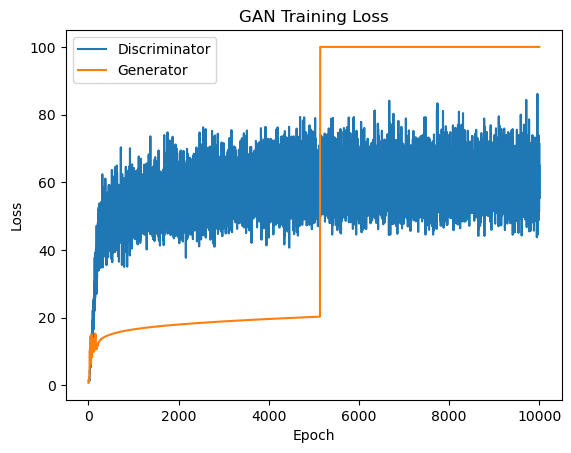

In [20]:

# create generator and discriminator
generator = Generator()

discriminator = Discriminator()

# train GAN
num_epochs = 1000
learning_rate=0.001
train_gan(generator, discriminator, train_dataloader, num_epochs)


In [24]:
# generate 600 MHz NMR spectra for input data at 60 MHz
for index,(test_tensor,_) in enumerate(test_dataloader):
    input_data = test_tensor
    output_data = generator(input_data).detach().numpy()
    print(output_data)
    print(input_data.shape)
          

[[[-1.7296832e-02  1.6037137e-03  8.4391840e-02 ... -1.1979267e-03
    2.2731824e-02  6.1556481e-02]]

 [[-1.5888970e-02  9.6164797e-05  8.1237309e-02 ... -1.7041788e-03
    2.1434279e-02  6.0790166e-02]]

 [[-1.4339173e-02  5.4359162e-04  8.1846476e-02 ... -1.0222830e-03
    2.0477453e-02  6.0116477e-02]]

 ...

 [[-1.5040141e-02  1.1090923e-03  8.0995597e-02 ...  4.8367679e-04
    2.0031476e-02  5.9829682e-02]]

 [[-1.8083390e-02  2.0944139e-03  8.5957475e-02 ... -1.5347190e-03
    2.2659691e-02  6.1909966e-02]]

 [[-1.8765019e-02  1.9949940e-03  8.7094069e-02 ... -2.1395236e-03
    2.3857819e-02  6.3048519e-02]]]
torch.Size([10, 1, 5500])


In [22]:
# plot the first 10 spectra in the output data
plt.figure(figsize=(10, 6))
plt.plot(output_data[0], label=f"Spectrum {i+1}")
plt.legend()
plt.title("Generated 600 MHz NMR Spectra")
plt.xlabel("Data Point")
plt.ylabel("Intensity")
plt.show()

NameError: name 'i' is not defined

<Figure size 1000x600 with 0 Axes>

In [25]:
df_y = pd.DataFrame(output_data)

ValueError: Must pass 2-d input. shape=(10, 1, 5500)